## Can you help detect toxic comments ― and minimize unintended model bias?

# Import the libraries

In [92]:
## for data
import json
import pandas as pd
import numpy as np
import os


## for plotting
import matplotlib.pyplot as plt
import seaborn as sns


## For Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model

## for processing
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import re
import string

import nltk

nltk.download('punkt')

from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

nltk.download('wordnet')
from nltk.corpus import wordnet

import html


[nltk_data] Downloading package punkt to /home/mo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/mo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Get the Data¶


In [93]:
DATASET_PATH = './Dataset/'
tweets = pd.read_csv(os.path.join(DATASET_PATH, 'trainTweets.csv'),usecols=['target','comment_text'])
print(tweets.shape)
print(tweets.columns)

tweets.head()

(1804874, 2)
Index(['target', 'comment_text'], dtype='object')


,target,comment_text
0,0.000000,"This is so cool. It's like, 'would you want yo..."
1,0.000000,Thank you!! This would make my life a lot less...
2,0.000000,This is such an urgent design problem; kudos t...
3,0.000000,Is this something I'll be able to install on m...
4,0.893617,haha you guys are a bunch of losers.


In [94]:
wantedRows = tweets[tweets['comment_text'].str.split().str.len()==1].index 
data =  tweets.drop(wantedRows, axis = 0)

In [95]:
wantedRows = data[data['comment_text'].str.split().str.len()>=50].index 
tweets =  data.drop(wantedRows, axis = 0)

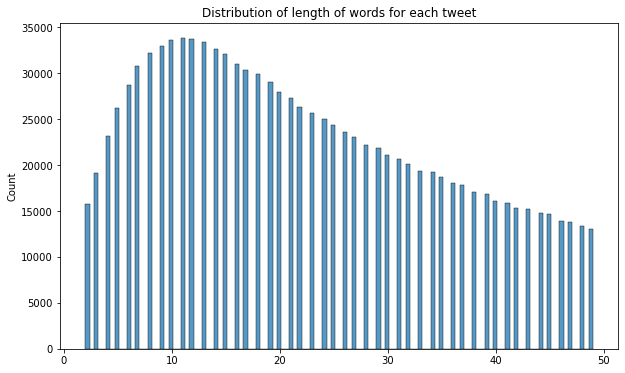

In [96]:
fig = plt.subplots(figsize =(10, 6));
x=[len(i.split()) for i in tweets['comment_text'].values]
plt.title("Distribution of length of words for each tweet");
sns.histplot(x);

we consider the tweets  only between 2 to 50 words

In [97]:
tweets.shape

(1110666, 2)

In [98]:
tweets['target']=round(tweets['target'])

In [99]:
tweets=tweets.reset_index()
tweets=tweets.drop(columns='index')

In [100]:
tweets.tail()

,target,comment_text
1110661,0.0,There's no whine like Alberta whine!
1110662,0.0,"If Alberta had given them nothing, you'd STILL..."
1110663,0.0,"Maybe the tax on ""things"" would be collected w..."
1110664,0.0,What do you call people who STILL think the di...
1110665,0.0,"thank you ,,,right or wrong,,, i am following ..."


In [101]:
tweets['target'].value_counts()

0.0    1037928
1.0      72738
Name: target, dtype: int64

In [102]:
from sklearn.model_selection import StratifiedShuffleSplit
split=StratifiedShuffleSplit(n_splits=1,test_size=0.01,random_state=42)
for train_index,test_index in split.split(tweets,tweets['target']):
    strat_train_set=tweets.loc[train_index]
    strat_test_set=tweets.loc[test_index]

In [109]:
strat_test_set.to_csv("./Dataset/tweets_sample.csv")

In [110]:
tweets_sample=pd.read_csv("./Dataset/tweets_sample.csv").drop(columns="Unnamed: 0")

In [111]:
tweets_sample

,target,comment_text
0,0.0,People call each other names all the time. Who...
1,1.0,How about closing all rivers for 10 years?\nKe...
2,0.0,"Multiple versions of facts, too. That one's f..."
3,0.0,Protests held on he weekend when we are off wo...
4,0.0,Bigger dogs aren't the answer. How many footb...
...,...,...
11102,0.0,"J. Bob, I've searched for it, but could not fi..."
11103,0.0,Off topic.....and you can get through college ...
11104,0.0,How so Bart?
11105,1.0,You are a snit stained retard..


## Explore the Data

In [14]:
[[i]  for i in tweets_sample['comment_text']]


[['People call each other names all the time. Who cares. Worry about something else. The collective soft skin of our society is unbelievable.'],
 ['How about closing all rivers for 10 years?\nKeep killing fish on the Hoh, the Kings will disappear for good.\nYou fools just want to kill everything with their nylon nets, no self control.'],
 ["Multiple versions of facts, too.  That one's from Rebel Media."],
 ['Protests held on he weekend when we are off work and able to help support would be much more effective.'],
 ["Bigger dogs aren't the answer.  How many football players do you see winning the Boston Marathon?"],
 ["Except that the hectares they wanted to buy weren't zoned for that purpose. \n\nThose running with the bit between their teeth on this one need to get off their high horse. I find all this religious-based PC-edness really tiresome."],
 ['Harper X 10 real men = Trudeau\n\nNot really that tough.'],
 ['Obstruction of Justice.\nViolating the Emoluments Clause .\nhttps://www.w

In [15]:
len(tweets_sample[tweets_sample['target']>0.5]) # number of Toixic comments

727

In [16]:
len(tweets_sample[tweets_sample['target']<0.5]) # number of not Toixic comments

10380

In [17]:
tweets_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11107 entries, 960113 to 502757
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   target        11107 non-null  float64
 1   comment_text  11107 non-null  object 
dtypes: float64(1), object(1)
memory usage: 260.3+ KB


In [18]:
tweets_sample.isnull().sum()

target          0
comment_text    0
dtype: int64

In [19]:
words_list= [nltk.tokenize.word_tokenize(i) for i in tweets_sample['comment_text']]
flat_list = []
for sublist in words_list:
    for item in sublist:
        flat_list.append(item)

In [20]:
len(set(flat_list))

25216

## Text Handling

### A - Text preprocessing


In [21]:
def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))


def to_lowercase(text):
    return text.lower()



def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def replace_numbers(text):
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip()


def remove_stopwords(words, stop_words):

    return [word for word in words if word not in stop_words]


def stem_words(words):
    """Stem words in text"""
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in words]

def lemmatize_words(words):
    """Lemmatize words in text"""

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

def lemmatize_verbs(words):
    """Lemmatize verbs in text"""

    lemmatizer = WordNetLemmatizer()
    return ' '.join([lemmatizer.lemmatize(word, pos='v') for word in words])

def text2words(text):
    return word_tokenize(text)

def normalize_text( text):
    text = remove_special_chars(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = replace_numbers(text)
    words = text2words(text)
    words = remove_stopwords(words, stop_words)
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)
    words=words.strip()
    return ''.join(words)

In [22]:
def normalize_corpus(corpus):
    return [normalize_text(t) for t in corpus]
  

In [23]:
tweets_sample['comment_text_clean'] = normalize_corpus(tweets_sample['comment_text'] )


In [24]:
words_list= [nltk.tokenize.word_tokenize(i) for i in tweets_sample['comment_text_clean']]
flat_list = []
for sublist in words_list:
    for item in sublist:
        flat_list.append(item)

In [25]:
len(set(flat_list))

16264

after cleaning the text number of words become 16264 from 25216

## B - Text preparation

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
top_words=10000
vectorizer = TfidfVectorizer(max_features=top_words)


bow = vectorizer.fit_transform(tweets_sample['comment_text_clean'])


In [27]:
data=bow.toarray()

In [28]:
df=pd.DataFrame(data,columns=vectorizer.vocabulary_)


In [29]:
y=tweets_sample['target']

In [30]:
data.sum()

33096.73201390404

In [31]:
from scipy.sparse import csr_matrix
tweets_csr = csr_matrix(data)

## Model Using ANN

In [32]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(tweets_csr, y, test_size=0.4, random_state=42)


In [33]:
x_train.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [35]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

In [36]:
history = model.fit(x_train.todense(),
                    y_train,
                    epochs=20,
                    batch_size=20,
                    validation_data=(x_val.todense(), y_val))

Epoch 1/20
334/334 [==============================] - 1s 3ms/step - loss: 0.3451 - binary_accuracy: 0.9344 - val_loss: 0.2367 - val_binary_accuracy: 0.9329
Epoch 2/20
334/334 [==============================] - 1s 2ms/step - loss: 0.2044 - binary_accuracy: 0.9356 - val_loss: 0.2250 - val_binary_accuracy: 0.9334
Epoch 3/20
334/334 [==============================] - 1s 2ms/step - loss: 0.1414 - binary_accuracy: 0.9457 - val_loss: 0.2241 - val_binary_accuracy: 0.9356
Epoch 4/20
334/334 [==============================] - 1s 2ms/step - loss: 0.0760 - binary_accuracy: 0.9745 - val_loss: 0.2473 - val_binary_accuracy: 0.9359
Epoch 5/20
334/334 [==============================] - 1s 2ms/step - loss: 0.0406 - binary_accuracy: 0.9860 - val_loss: 0.2735 - val_binary_accuracy: 0.9314
Epoch 6/20
334/334 [==============================] - 1s 2ms/step - loss: 0.0210 - binary_accuracy: 0.9955 - val_loss: 0.3023 - val_binary_accuracy: 0.9320
Epoch 7/20
334/334 [==============================] - 1s 2ms/ste

## Model Using LSTM

In [48]:
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Dense

from keras.preprocessing import sequence
from keras.models import Sequential


In [38]:
data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [54]:
xtrain, xval, ytrain, yval = train_test_split(data, y, test_size=0.4, random_state=42)


In [55]:
max_tweet_length=50
xtrain = pad_sequences(xtrain, maxlen=max_tweet_length)
xtest=sequence.pad_sequences(xval,maxlen=max_tweet_length)


In [66]:
embedding_vector_length=60

In [77]:
LSTMmodel=Sequential()
LSTMmodel.add(Embedding(top_words,embedding_vector_length,input_length=max_tweet_length))
LSTMmodel.add(LSTM(300))
LSTMmodel.add(Dense(1,activation='sigmoid'))

In [78]:
LSTMmodel.compile(loss='binary_crossentropy',optimizer=optimizers.Adam(learning_rate=0.1),metrics=['accuracy'])
print(LSTMmodel.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 60)            600000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 300)               433200    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 301       
Total params: 1,033,501
Trainable params: 1,033,501
Non-trainable params: 0
_________________________________________________________________
None


In [79]:
LSTMhistory=LSTMmodel.fit(xtrain,ytrain,batch_size=200,epochs=20,validation_data=(xtest,yval))

Epoch 1/20
34/34 [==============================] - 10s 234ms/step - loss: 0.4232 - accuracy: 0.9098 - val_loss: 0.2472 - val_accuracy: 0.9329
Epoch 2/20
34/34 [==============================] - 7s 221ms/step - loss: 0.2427 - accuracy: 0.9356 - val_loss: 0.2619 - val_accuracy: 0.9329
Epoch 3/20
34/34 [==============================] - 7s 222ms/step - loss: 0.2738 - accuracy: 0.9356 - val_loss: 0.2460 - val_accuracy: 0.9329
Epoch 4/20
34/34 [==============================] - 8s 222ms/step - loss: 0.2736 - accuracy: 0.9356 - val_loss: 0.2520 - val_accuracy: 0.9329
Epoch 5/20
34/34 [==============================] - 7s 221ms/step - loss: 0.2507 - accuracy: 0.9356 - val_loss: 0.2541 - val_accuracy: 0.9329
Epoch 6/20
34/34 [==============================] - 7s 219ms/step - loss: 0.2458 - accuracy: 0.9356 - val_loss: 0.3036 - val_accuracy: 0.9329
Epoch 7/20
34/34 [==============================] - 7s 219ms/step - loss: 0.2570 - accuracy: 0.9356 - val_loss: 0.2534 - val_accuracy: 0.9329
Epoch